In [1]:
# Making Extinction Proxy 
# Figure 8 (as of now) 

In [2]:
# Loading RC data 

import pickle, os 
from pathlib import Path

data_dir = Path(os.getcwd()).parent / "assets" 

with open(data_dir / "NRCB1.pickle", "rb") as f: 
    NRCB1 = pickle.load(f)
with open(data_dir / "NRCB2.pickle", "rb") as f: 
    NRCB2 = pickle.load(f) 
with open(data_dir / "NRCB3.pickle", "rb") as f: 
    NRCB3 = pickle.load(f) 
with open(data_dir / "NRCB4.pickle", "rb") as f: 
    NRCB4 = pickle.load(f)

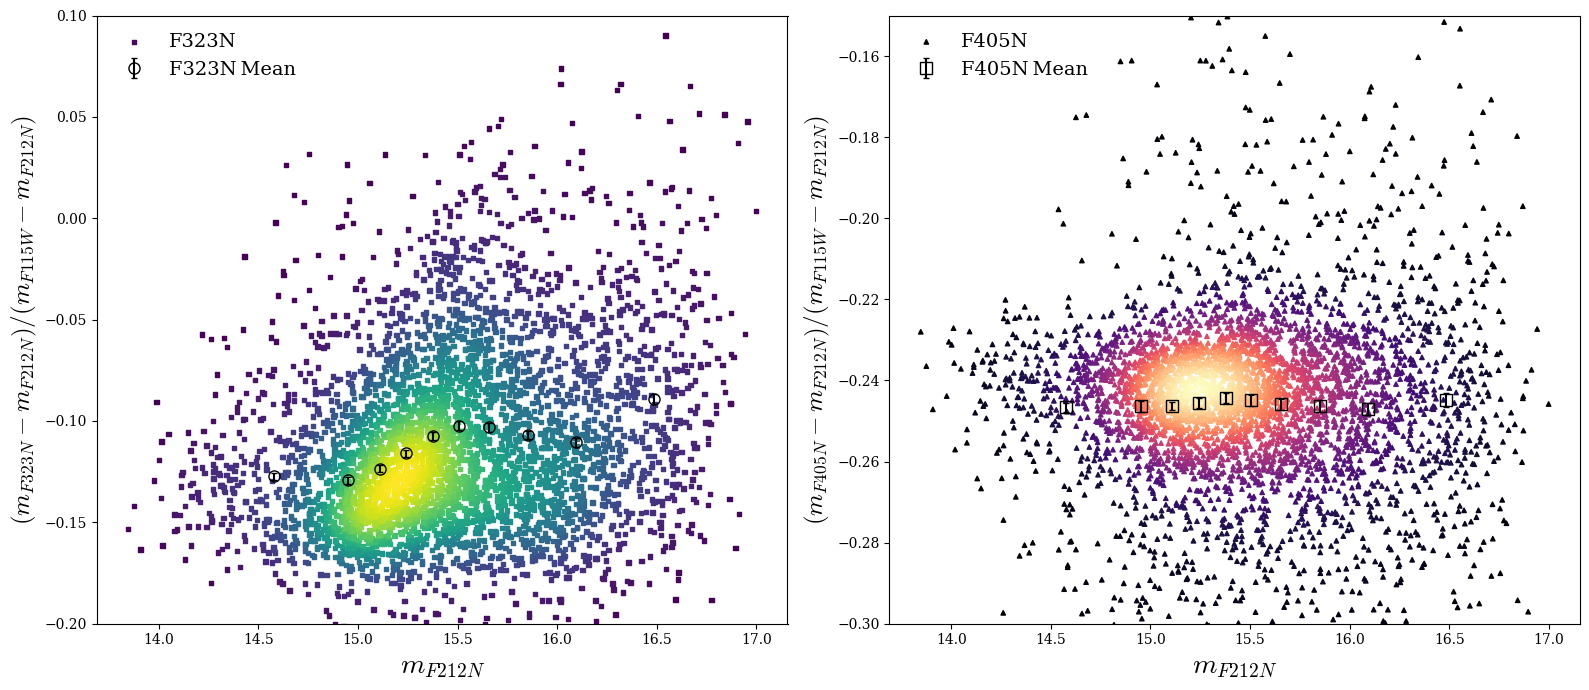

In [4]:
# Plotting NRCB1 Only 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import linregress, gaussian_kde 

plt.rcParams.update({
    "font.family"      : "serif",
    "mathtext.fontset" : "cm",                
})

figure, axis = plt.subplots(1, 2, figsize=(16, 7)) 

mF115W = NRCB1["mF115W"] 
mF212N = NRCB1["mF212N"] 
mF323N = NRCB1["mF323N"] 
mF405N = NRCB1["mF405N"] 

finite_mask = (
    np.isfinite(mF115W) & 
    np.isfinite(mF212N) & 
    np.isfinite(mF323N) & 
    np.isfinite(mF405N) 
) 
mF115W = mF115W[finite_mask] 
mF212N = mF212N[finite_mask] 
mF323N = mF323N[finite_mask] 
mF405N = mF405N[finite_mask] 

# x, y coordinates 
x = mF212N 
y_F323N = (mF323N - mF212N) / (mF115W - mF212N) 
y_F405N = (mF405N - mF212N) / (mF115W - mF212N) 

# coloring by density 
xyF323N = np.vstack([x, y_F323N])
kde_F323N = gaussian_kde(xyF323N)(xyF323N) 
xyF405N = np.vstack([x, y_F405N])
kde_F405N = gaussian_kde(xyF405N)(xyF405N) 

axis[0].scatter(x, y_F323N, c=kde_F323N, cmap="viridis", marker='s', s=10, label="F323N") 
axis[1].scatter(x, y_F405N, c=kde_F405N, cmap="magma", marker='^', s=10, label="F405N") 

Nbins = 10                                  
edges = np.quantile(x, np.linspace(0, 1, Nbins + 1))
idx   = np.digitize(x, edges[1:-1])        

def bin_stats(y):
    mu  = np.array([y[idx == k].mean() for k in range(Nbins)])
    se = np.array([y[idx == k].std(ddof=1)  / np.sqrt((idx == k).sum())
                   for k in range(Nbins)])
    xc = np.array([x[idx == k].mean() for k in range(Nbins)])
    return xc, mu, se

xc323, mu323, se323 = bin_stats(y_F323N)
xc405, mu405, se405 = bin_stats(y_F405N)

axis[0].errorbar(xc323, mu323, yerr=se323, fmt='o',
              mfc='none', c='k', ms=8, capsize=2, label='F323N Mean')
axis[1].errorbar(xc405, mu405, yerr=se405, fmt='s',
              mfc='none', c='k', ms=8, capsize=2, label='F405N Mean')


axis[0].set_ylabel(r"$(m_{F323N}- m_{F212N}) / (m_{F115W} - m_{F212N})$", fontsize=18)
axis[1].set_ylabel(r"$(m_{F405N}- m_{F212N}) / (m_{F115W} - m_{F212N})$", fontsize=18) 
axis[0].set_xlabel(r"$m_{F212N}$", fontsize=20) 
axis[1].set_xlabel(r"$m_{F212N}$", fontsize=20) 
axis[0].legend(frameon=False, loc="upper left", fontsize=14)
axis[1].legend(frameon=False, loc="upper left", fontsize=14)

axis[0].set_ylim(-0.2, 0.1) 
axis[1].set_ylim(-0.3, -0.15)

plt.tight_layout()
plt.savefig("/Users/vinland/mulab/paper/proxy.png", dpi=500)

In [19]:
import tqdm

x_lo, x_hi = 15, 15.4
y_lo, y_hi = -0.15, -0.1
def mask(x_, y_, m115_, m212_):
    denom = (m115_ - m212_)
    return (x_ >= x_lo) & (x_ <= x_hi) & (y_ >= y_lo) & (y_ <= y_hi) & np.isfinite(denom) & (np.abs(denom) > 1e-3)

meF323N = NRCB1["meF323N"][finite_mask] 
meF212N = NRCB1["meF212N"][finite_mask] 
meF115W = NRCB1["meF115W"][finite_mask]

mask_obs = mask(mF212N, y_obs, mF115W, mF212N)
slope_obs = linregress(mF212N[mask_obs], y_obs[mask_obs]).slope

n = 10_000
slopes = np.empty(n)

for j in tqdm.tqdm(range(n)):
    m115 = mF115W + np.random.normal(0, meF115W, size=mF115W.shape)
    m212 = mF212N + np.random.normal(0, meF212N, size=mF212N.shape)
    m323 = mF323N + np.random.normal(0, meF323N, size=mF323N.shape)

    y = (m323 - m212) / (m115 - m212)
    slopes[j] = linregress(mF212N[mask_obs], y[mask_obs]).slope

p_two_tailed = (np.abs(slopes) >= np.abs(slope_obs)).mean()
print(f"slope: {slope_obs:.4f}")
print(f"two-tailed p: {p_two_tailed:.4f}")

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2272.89it/s]

slope: 0.0157
two-tailed p: 0.4979


n=1090, slope=0.0143, p(two-tailed)=0.3900, tau=0.085 (p=2.4e-05)


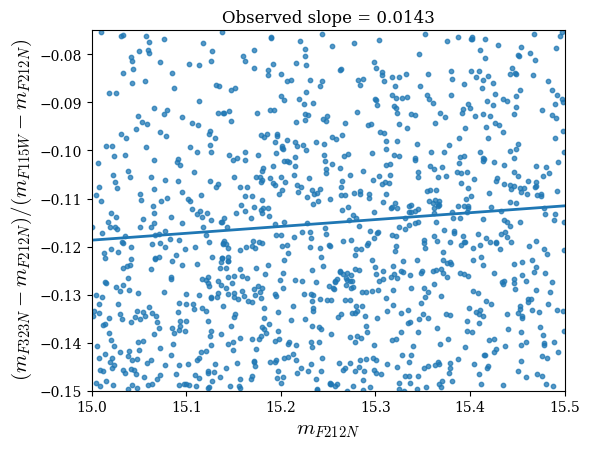

In [21]:
from scipy.stats import linregress, kendalltau, spearmanr
from numpy.polynomial.polynomial import polyfit as polyfit_np  


def sigma_y_ratio(a, b, c, sa, sb, sc, eps=1e-12):
    den   = (c - b)
    den2  = den**2
    den   = np.where(np.abs(den) < eps, np.sign(den) * eps, den)  
    den2  = np.where(den2 < eps**2, eps**2, den2)

    dy_da = 1.0 / den
    dy_db = (a - c) / den2
    dy_dc = (a - b) / den2

    return np.sqrt((dy_da * sa)**2 + (dy_db * sb)**2 + (dy_dc * sc)**2)


def wls_slope(x, y, w):
    w = np.asarray(w)
    x = np.asarray(x)
    y = np.asarray(y)
    W  = w**2 
    S  = np.sum(W)
    Sx = np.sum(W * x)
    Sy = np.sum(W * y)
    Sxx= np.sum(W * x * x)
    Sxy= np.sum(W * x * y)
    denom = (S * Sxx - Sx * Sx)
    
    if denom <= 0:
        slope = linregress(x, y).slope
        intercept = np.average(y) - slope * np.average(x)
        return slope, intercept
    slope = (S * Sxy - Sx * Sy) / denom
    intercept = (Sy - slope * Sx) / S
    return slope, intercept


def analyze_window(
    mF115W, mF212N, mF323N,
    meF115W, meF212N, meF323N,
    x_lo=15.0, x_hi=15.5, y_lo=-0.15, y_hi=-0.075,
    eps=1e-3, rng_seed=42, n_mc=10_000,
    make_plot=True, use_rank_tests=True
):
    a0 = np.asarray(mF323N, dtype=float)
    b0 = np.asarray(mF212N, dtype=float)
    c0 = np.asarray(mF115W, dtype=float)

    sa = np.asarray(meF323N, dtype=float)
    sb = np.asarray(meF212N, dtype=float)
    sc = np.asarray(meF115W, dtype=float)

    y_obs = (a0 - b0) / (c0 - b0)
    x_obs = b0

    finite = np.isfinite(a0) & np.isfinite(b0) & np.isfinite(c0) & \
             np.isfinite(sa) & np.isfinite(sb) & np.isfinite(sc)
    denom_good = np.isfinite(c0 - b0) & (np.abs(c0 - b0) > eps)

    mask_obs = (
        finite & denom_good &
        (x_obs >= x_lo) & (x_obs <= x_hi) &
        (y_obs >= y_lo) & (y_obs <= y_hi)
    )

    idx = np.where(mask_obs)[0]
    if idx.size < 5:
        raise ValueError(f"Too few stars in window: {idx.size}")

    x0, y0 = x_obs[idx], y_obs[idx]
    a0, b0, c0, sa, sb, sc = a0[idx], b0[idx], c0[idx], sa[idx], sb[idx], sc[idx]

   
    sy = sigma_y_ratio(a0, b0, c0, sa, sb, sc, eps=eps/10.0)
    w = 1.0 / np.clip(sy, 1e-6, np.inf)

    slope_obs, intercept_obs = wls_slope(x0, y0, w)

    if make_plot:
        plt.figure(figsize=(6.0, 4.6))
        plt.scatter(x0, y0, s=10, alpha=0.75)
        xx = np.linspace(x_lo, x_hi, 100)
        yy = intercept_obs + slope_obs * xx
        plt.plot(xx, yy, lw=2)
        plt.xlim(x_lo, x_hi)
        plt.ylim(y_lo, y_hi)
        plt.xlabel(r"$m_{F212N}$", fontsize=15)
        plt.ylabel(r"$\,(m_{F323N}-m_{F212N})/(m_{F115W}-m_{F212N})$", fontsize=15)
        plt.title(f"Observed slope = {slope_obs:.4f}")
        plt.tight_layout()

    rng = np.random.default_rng(rng_seed)
    slopes = np.empty(n_mc, dtype=float)
    k = 0

    for _ in range(n_mc):
        a = a0 + rng.normal(0.0, sa)
        b = b0 + rng.normal(0.0, sb)
        c = c0 + rng.normal(0.0, sc)

        den = c - b
        good = np.isfinite(den) & (np.abs(den) > eps)
        if good.sum() < 5:
            continue

        x = b[good]
        y = (a[good] - b[good]) / den[good]
        ww = w[good]

        m, _ = wls_slope(x, y, ww)
        slopes[k] = m
        k += 1

    slopes = slopes[:k]
    if slopes.size < n_mc * 0.7:
        print(f"warning: many draws rejected ({slopes.size}/{n_mc}). consider larger eps.")

    p_two = (np.abs(slopes) >= abs(slope_obs)).mean()

    out = {
        "n_stars": idx.size,
        "slope_obs": slope_obs,
        "intercept_obs": intercept_obs,
        "p_two_tailed_mc": float(p_two),
        "slopes_mc": slopes,
        "idx_used": idx,
    }

    if use_rank_tests:
        tau,  p_tau  = kendalltau(x0, y0)
        rho,  p_rho  = spearmanr(x0, y0)
        out.update({
            "kendall_tau": float(tau), "kendall_tau_p": float(p_tau),
            "spearman_rho": float(rho), "spearman_rho_p": float(p_rho),
        })

    return out


mF323N = NRCB1["mF323N"][finite_mask]
mF212N = NRCB1["mF212N"][finite_mask]
mF115W = NRCB1["mF115W"][finite_mask]
meF323N = NRCB1["meF323N"][finite_mask]
meF212N = NRCB1["meF212N"][finite_mask]
meF115W = NRCB1["meF115W"][finite_mask]

res = analyze_window(
    mF115W, mF212N, mF323N,
    meF115W, meF212N, meF323N,
    x_lo=15.0, x_hi=15.5, y_lo=-0.15, y_hi=-0.075,
    n_mc=10_000, rng_seed=7, make_plot=True
)

print(
    f"n={res['n_stars']}, slope={res['slope_obs']:.4f}, "
    f"p(two-tailed)={res['p_two_tailed_mc']:.4f}, "
    f"tau={res['kendall_tau']:.3f} (p={res['kendall_tau_p']:.3g})"
)

In [12]:
import numpy as np
from scipy.stats import linregress

x_lo, x_hi = 15.0, 15.4
y_lo, y_hi = -0.15, -0.10
DENOM_EPS = 1e-3
rng = np.random.default_rng(7)

m323_obs = NRCB1["mF323N"][finite_mask].to_numpy()
m212_obs = NRCB1["mF212N"][finite_mask].to_numpy()
m115_obs = NRCB1["mF115W"][finite_mask].to_numpy()
s323      = NRCB1["meF323N"][finite_mask].to_numpy()
s212      = NRCB1["meF212N"][finite_mask].to_numpy()
s115      = NRCB1["meF115W"][finite_mask].to_numpy()

y_obs = (m323_obs - m212_obs) / (m115_obs - m212_obs)
mask = (
    (m212_obs >= x_lo) & (m212_obs <= x_hi) &
    (y_obs   >= y_lo) & (y_obs   <= y_hi) &
    np.isfinite(m115_obs - m212_obs) & (np.abs(m115_obs - m212_obs) > DENOM_EPS)
)
if mask.sum() < 5:
    raise ValueError(f"Too few stars in window: {mask.sum()}")

m115 = m115_obs[mask].astype(float)
m212 = m212_obs[mask].astype(float)
m323 = m323_obs[mask].astype(float)
s115 = s115[mask].astype(float)
s212 = s212[mask].astype(float)
s323 = s323[mask].astype(float)
y_obs = y_obs[mask]

slope_obs = linregress(m212, y_obs).slope

y_star = float(np.mean(y_obs))


m115_star = m115.copy()
m212_star = m212.copy()
m323_star = m212_star + y_star * (m115_star - m212_star)


n = 10_000
slopes = np.empty(n); k = 0
for _ in range(n):
    a = m323_star + rng.normal(0, s323)   
    b = m212_star + rng.normal(0, s212)   
    c = m115_star + rng.normal(0, s115)  

    den = c - b
    good = np.isfinite(den) & (np.abs(den) > DENOM_EPS)
    if good.sum() < 5:
        continue

    x = b[good]
    y = (a[good] - b[good]) / den[good]
    slopes[k] = linregress(x, y).slope
    k += 1

slopes = slopes[:k]
p_two_tailed = (np.abs(slopes) >= abs(slope_obs)).mean()
lo, hi = np.percentile(slopes, [16, 84])

print(f"n_stars={mask.sum()}")
print(f"observed slope = {slope_obs:.5f}")
print(f"strict flat-null MC p(two-tailed) = {p_two_tailed:.4f}")
print(f"null slope 68% interval = [{lo:.5f}, {hi:.5f}]")
print(f"y* (flat latent ratio) = {y_star:.5f}")

n_stars=708
observed slope = 0.01570
strict flat-null MC p(two-tailed) = 0.0000
null slope 68% interval = [-0.00074, 0.00020]
y* (flat latent ratio) = -0.12595
